# Analyzing annotations of linguistic data from paired building experiment

We ran two separate annotations studies, each with two naive participants from the lab.

In [ ]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("../../")
sys.path.append("../../utils")
sys.path.append("../../analysis/utils")


import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.cluster import AffinityPropagation
from sklearn.manifold import TSNE

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# import drawing_utils as drawing
import importlib
import scoring

In [ ]:
## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('../../')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

### load annotations and wrangle to match

In [3]:
# first set of annotations (cogsci 2021)
df_jj = pd.read_csv('{}/results/csv/JJ_content.csv'.format(analysis_dir))

# second set of annotations (2023)
df_zc = pd.read_csv('{}/results/csv/ref_exp_annotations_2023.csv'.format(analysis_dir))

df_chat = pd.read_csv('{}/results/csv/df_chat_ids_cogsci21.csv'.format(analysis_dir))

In [4]:
df_chat.loc[:,'dyad_gameid'] = df_chat.gameid
df_chat.loc[:,'turn_num'] = df_chat.turnNum
df_chat.loc[:,'trial_num'] = df_chat.trialNum

In [5]:
df_jj.loc[:,'message_num'] = (df_jj.turnNum/2).astype(int)

df_jj_small = df_jj[['gameid','trialNum', 'message_num','turnNum','message','block_justin', 'toer_justin',
       'scene_justin', 'Flagged', 'phrases_justin', 'block_julia',
       'tower_juli', 'scene_juli', 'phrases_julia']].copy()

df_jj_small.rename(
            columns={
            'gameid': 'dyad_gameid',
            'trialNum': 'trial_num',
            'turnNum': 'turn_num',
            'toer_justin': 'tower_justin',
            'tower_juli': 'tower_julia',
            'scene_juli': 'scene_julia'
            # add more column names as needed
        }, inplace=True)

df_jj_small = df_jj_small.merge(df_chat[['dyad_gameid','trial_num','turn_num','message_id']], on = ['dyad_gameid','trial_num','turn_num'], how = 'left')

df_jj_small = df_jj_small.sort_values(['dyad_gameid','trial_num','message_num']).reset_index(drop=True)

df_jj_small

,dyad_gameid,trial_num,message_num,turn_num,message,block_justin,tower_justin,scene_justin,Flagged,phrases_justin,block_julia,tower_julia,scene_julia,phrases_julia,message_id
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,0,0,two blue blocks on left and right side of left...,2,0,0,NaN,two blue blocks,2.0,0,0.0,two blue,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,1,2,two red block on top of left blue block just p...,2,0,0,NaN,two red block,2.0,0,0.0,two red,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,2,4,two red block one space apart on right line,2,0,0,NaN,two red block,2.0,0,0.0,two red,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d
3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,3,6,one blue block on top red block,1,0,0,NaN,one blue,1.0,0,0.0,blue,9f118a42-9cd3-a795-5edd-9aae7f104dcf
4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,4,8,"on left red line, on more red block on top of ...",1,0,0,NaN,red block,1.0,0,0.0,red,dc786e74-3ae7-ab54-169e-98cea7713b3c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,11,1,2,same on the opposite side,2,0,0,1.0,same,0.0,1,0.0,same,ae9e8d03-8498-3111-371a-239070c742d0
2139,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,11,2,4,close it up with two blues,2,0,0,NaN,two blues,2.0,0,0.0,two blues,24b27e83-01cb-d9c2-d35f-581e3648431f
2140,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,11,3,6,take a blue and place it to the right of right...,1,0,0,NaN,a blue,1.0,0,0.0,blue,17668e8a-78ca-810e-7428-63563c91e458
2141,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,11,4,8,another blue placed next to it on the left side,1,0,0,NaN,another blue,1.0,0,0.0,blue,a622053d-d5ff-7894-46ac-32019ab1874e


In [74]:
# melt and pivot

suffix_columns = [col for col in df_jj_small.columns if col.endswith('_justin') or col.endswith('_julia')]

suffix_df = df_jj_small[['dyad_gameid','trial_num','turn_num','message_id'] + suffix_columns]

# Then, melt the DataFrame with the new index as the identifier variable
melted_df = pd.melt(suffix_df, id_vars=['dyad_gameid','trial_num','turn_num','message_id'], var_name='Type', value_name='Value')

# melted_df

# # Now, split the 'Type' column to separate the suffix and create a new column
melted_df[['Category', 'Suffix']] = melted_df['Type'].str.split('_', expand=True)

# # Drop the 'Type' column as it's no longer needed
melted_df.drop(columns=['Type'], inplace=True)
melted_df
# # Finally, pivot the table to the desired format
pivoted_df = melted_df.pivot(index=['dyad_gameid','trial_num','turn_num','message_id','Suffix'], 
                             columns='Category', values='Value').reset_index()

pivoted_df = pivoted_df.rename(columns={'Suffix':'workerID'})


In [75]:
# adjust a bad annotation
pivoted_df.loc[pivoted_df['tower'] == 'L','tower'] = 1

In [87]:
# convert to ints
pivoted_df.loc[:,'block'] = pivoted_df['block'].fillna(0).astype(int)
pivoted_df.loc[:,'tower'] = pivoted_df['tower'].fillna(0).astype(int)
pivoted_df.loc[:,'scene'] = pivoted_df['scene'].fillna(0).astype(int)

In [88]:
pivoted_df

Category,dyad_gameid,trial_num,turn_num,message_id,workerID,block,phrases,scene,tower
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,julia,2,two blue,0,0
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,justin,2,two blue blocks,0,0
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,julia,2,two red,0,0
3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,justin,2,two red block,0,0
4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,4,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d,julia,2,two red,0,0
...,...,...,...,...,...,...,...,...,...
4281,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,11,6,17668e8a-78ca-810e-7428-63563c91e458,justin,1,a blue,0,0
4282,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,11,8,a622053d-d5ff-7894-46ac-32019ab1874e,julia,1,blue,0,0
4283,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,11,8,a622053d-d5ff-7894-46ac-32019ab1874e,justin,1,another blue,0,0
4284,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,11,10,bcee7fb1-543c-41b5-6466-18914a3eacf0,julia,2,two reds,0,0


In [501]:
# merge in metadata
pivoted_df_merged = pivoted_df.merge(df_jj_small[['dyad_gameid','message_id','message_num','message']], 
                 on=['message_id','dyad_gameid'], how='left')

pivoted_df_merged

,dyad_gameid,trial_num,turn_num,message_id,workerID,block,phrases,scene,tower,message_num,message
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,julia,2,two blue,0,0,0,two blue blocks on left and right side of left...
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,0,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,justin,2,two blue blocks,0,0,0,two blue blocks on left and right side of left...
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,julia,2,two red,0,0,1,two red block on top of left blue block just p...
3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,2,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,justin,2,two red block,0,0,1,two red block on top of left blue block just p...
4,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,4,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d,julia,2,two red,0,0,2,two red block one space apart on right line
...,...,...,...,...,...,...,...,...,...,...,...
4281,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,11,6,17668e8a-78ca-810e-7428-63563c91e458,justin,1,a blue,0,0,3,take a blue and place it to the right of right...
4282,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,11,8,a622053d-d5ff-7894-46ac-32019ab1874e,julia,1,blue,0,0,4,another blue placed next to it on the left side
4283,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,11,8,a622053d-d5ff-7894-46ac-32019ab1874e,justin,1,another blue,0,0,4,another blue placed next to it on the left side
4284,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,11,10,bcee7fb1-543c-41b5-6466-18914a3eacf0,julia,2,two reds,0,0,5,stack two reds on the left edge


In [502]:
pivoted_df_merged['content'] = pivoted_df_merged['phrases'].str.lower()
pivoted_df_merged['content'] = pivoted_df_merged['content'].str.replace(r'~', '')
pivoted_df_merged['content'] = pivoted_df_merged['content'].str.replace(r'\(', '')
pivoted_df_merged['content'] = pivoted_df_merged['content'].str.replace(r'\)', '')
pivoted_df_merged['content'] = pivoted_df_merged['content'].str.replace(r'\,', '')
pivoted_df_merged['content'] = pivoted_df_merged['content'].str.replace(r"\'", '')
pivoted_df_merged['content'] = pivoted_df_merged['content'].str.replace(r"\:", '')
pivoted_df_merged['content'] = pivoted_df_merged['content'].str.replace(r"\;", '')

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_92086/181162583.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  pivoted_df_merged['content'] = pivoted_df_merged['content'].str.replace(r'\(', '')
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_92086/181162583.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  pivoted_df_merged['content'] = pivoted_df_merged['content'].str.replace(r'\)', '')
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_92086/181162583.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  pivoted_df_merged['content'] = pivoted_df_merged['content'].str.replace(r'\,', '')
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_92086/181162583.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  pivoted_df_merged['content'] = pivoted_df_m

In [90]:
df_zc_small = df_zc[['workerID','message_id','dyad_gameid','msgNum','message','block','tower','refExps']].copy()

df_zc_small = df_zc_small.merge(df_chat[['message_id','trialNum']], 
                               how ='left',
                               on = 'message_id')

df_zc_small.rename(
            columns={
            'trialNum': 'trial_num',
            'msgNum': 'message_num'
        }, inplace=True)


df_zc_small.loc[:,'turn_num'] = (df_zc_small.message_num*2).astype(int)

df_zc_small = df_zc_small.sort_values(['workerID','dyad_gameid','trial_num','message_num']).reset_index(drop=True)


df_zc_small

,workerID,message_id,dyad_gameid,message_num,message,block,tower,refExps,trial_num,turn_num
0,charles,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,two blue blocks on left and right side of left...,2,0,"two blue block,",0.0,0
1,charles,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,two red block on top of left blue block just p...,2,0,"two red block,",0.0,2
2,charles,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d,0110-5784fec9-109a-4d7a-a343-4820f4d42144,2,two red block one space apart on right line,2,0,"two red block,",0.0,4
3,charles,9f118a42-9cd3-a795-5edd-9aae7f104dcf,0110-5784fec9-109a-4d7a-a343-4820f4d42144,3,one blue block on top red block,1,0,"one blue block,",0.0,6
4,charles,dc786e74-3ae7-ab54-169e-98cea7713b3c,0110-5784fec9-109a-4d7a-a343-4820f4d42144,4,"on left red line, on more red block on top of ...",1,0,"red block,",0.0,8
...,...,...,...,...,...,...,...,...,...,...
4281,zoe,ae9e8d03-8498-3111-371a-239070c742d0,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,1,same on the opposite side,1,0,"same,",11.0,2
4282,zoe,24b27e83-01cb-d9c2-d35f-581e3648431f,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,2,close it up with two blues,2,0,"two blues,",11.0,4
4283,zoe,17668e8a-78ca-810e-7428-63563c91e458,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,3,take a blue and place it to the right of right...,1,0,"blue,",11.0,6
4284,zoe,a622053d-d5ff-7894-46ac-32019ab1874e,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,4,another blue placed next to it on the left side,1,0,"blue,",11.0,8


In [504]:
df_zc_small['content'] = df_zc_small['refExps'].str.lower()
df_zc_small['content'] = df_zc_small['content'].str.replace(r'~', '')
df_zc_small['content'] = df_zc_small['content'].str.replace(r'\(', '')
df_zc_small['content'] = df_zc_small['content'].str.replace(r'\)', '')
df_zc_small['content'] = df_zc_small['content'].str.replace(r'\,', '')
df_zc_small['content'] = df_zc_small['content'].str.replace(r"\'", '')
df_zc_small['content'] = df_zc_small['content'].str.replace(r"\:", '')
df_zc_small['content'] = df_zc_small['content'].str.replace(r"\;", '')

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_92086/4022839796.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_zc_small['content'] = df_zc_small['content'].str.replace(r'\(', '')
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_92086/4022839796.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_zc_small['content'] = df_zc_small['content'].str.replace(r'\)', '')
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_92086/4022839796.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_zc_small['content'] = df_zc_small['content'].str.replace(r'\,', '')
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_92086/4022839796.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_zc_small['content'] = df_zc_small['content'].str.replace(r"\'", '')
/var

In [506]:
df_ref_exps = pd.concat([pivoted_df_merged, df_zc_small], ignore_index=True)

df_ref_exps = df_ref_exps.merge(df_chat[['message_id','leftTarget','rightTarget']], how ='left', on='message_id')
df_ref_exps.loc[:,'tower_pair'] = df_ref_exps.leftTarget + '_' + df_ref_exps.rightTarget
df_ref_exps.loc[:,'rep'] = ((df_ref_exps.trial_num + 1)/ 4).astype(int) + 1

In [511]:
df_ref_exps.loc[:,'content'] = df_ref_exps.loc[:,'content'].astype(str)

In [512]:
df_ref_exps.to_csv('{}/results/csv/df_ref_exps.csv'.format(analysis_dir))

# Inter-rater Reliability

In [499]:
df_ref_exps_melt = df_ref_exps.melt(id_vars=['workerID','dyad_gameid','message_id','message_num','trial_num','tower_pair','rep'], value_vars=['block','tower'], value_name='n_refs')
df_ref_exps_melt = df_ref_exps_melt.rename(columns={'variable': 'exp_type'})
df_ref_exps_melt

,workerID,dyad_gameid,message_id,message_num,trial_num,tower_pair,rep,exp_type,n_refs
0,julia,0110-5784fec9-109a-4d7a-a343-4820f4d42144,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,0,0.0,L_Pi,1,block,2
1,justin,0110-5784fec9-109a-4d7a-a343-4820f4d42144,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,0,0.0,L_Pi,1,block,2
2,julia,0110-5784fec9-109a-4d7a-a343-4820f4d42144,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,1,0.0,L_Pi,1,block,2
3,justin,0110-5784fec9-109a-4d7a-a343-4820f4d42144,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,1,0.0,L_Pi,1,block,2
4,julia,0110-5784fec9-109a-4d7a-a343-4820f4d42144,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d,2,0.0,L_Pi,1,block,2
...,...,...,...,...,...,...,...,...,...
17139,zoe,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,ae9e8d03-8498-3111-371a-239070c742d0,1,11.0,Pi_L,4,tower,0
17140,zoe,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,24b27e83-01cb-d9c2-d35f-581e3648431f,2,11.0,Pi_L,4,tower,0
17141,zoe,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,17668e8a-78ca-810e-7428-63563c91e458,3,11.0,Pi_L,4,tower,0
17142,zoe,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,a622053d-d5ff-7894-46ac-32019ab1874e,4,11.0,Pi_L,4,tower,0


In [500]:
df_ref_exps_melt.to_csv('{}/results/csv/df_ref_exps_melt.csv'.format(analysis_dir))

In [123]:
df_ref_exps_table = df_ref_exps.pivot(index='message_id', columns='workerID', values=['block','tower'])
df_ref_exps_table

block                    tower        \
workerID                             charles julia justin zoe charles julia   
message_id                                                                    
00183cfe-ceb0-9220-7984-f33f61c61ae4       1     1      1   3       0     0   
0021b632-3246-b7d9-bb29-66398e4a295d       1     1      1   1       0     0   
002b2f92-8dc5-7bd9-6689-ef79f8c3c461       1     1      1   1       0     0   
002f9cc4-096b-faff-f5b7-751f497e28aa       1     1      1   1       0     0   
004cdaf0-0ed9-1a32-4f0f-a9db4b6a3fea       1     1      1   1       0     0   
...                                      ...   ...    ...  ..     ...   ...   
ff52f3ab-afe3-e7ea-ede8-79c21541b74a       4     4      4   4       0     0   
ff9e16ef-3a0b-9373-567f-fb07cbc96874       2     1      2   1       0     0   
ffb59512-fa04-a706-ef8d-ff9bfae3fcee       1     1      1   1       0     0   
ffbdfd47-dc79-72f0-1338-94b3854ca896       4     4      4   4       0     2   
ffc573d5-fd0b-a70e-385a-f4635e4af862       0     0      0   0       1     1   

                                                 
workerID                             justin zoe  
message_id                                       
00183cfe-ceb0-9220-7984-f33f61c61ae4      0   0  
0021b632-3246-b7d9-bb29-66398e4a295d      0   0  
002b2f92-8dc5-7bd9-6689-ef79f8c3c461      0   0  
002f9cc4-096b-faff-f5b7-751f497e28aa      0   0  
004cdaf0-0ed9-1a32-4f0f-a9db4b6a3fea      0   0  
...                                     ...  ..  
ff52f3ab-afe3-e7ea-ede8-79c21541b74a      0   0  
ff9e16ef-3a0b-9373-567f-fb07cbc96874      0   0  
ffb59512-fa04-a706-ef8d-ff9bfae3fcee      0   0  
ffbdfd47-dc79-72f0-1338-94b3854ca896      1   1  
ffc573d5-fd0b-a70e-385a-f4635e4af862      1   1  

[2143 rows x 8 columns]

In [431]:
prop_all_agree_block = np.mean(
    (df_ref_exps_table['block','charles'] == df_ref_exps_table['block','julia']) &\
    (df_ref_exps_table['block','julia'] == df_ref_exps_table['block','justin']) &\
    (df_ref_exps_table['block','justin'] == df_ref_exps_table['block','zoe']))

print('%.1f' % (prop_all_agree_block*100) + '% total agreement on blocks') 

82.7% total agreement on blocks


In [433]:
prop_all_agree_tower = np.mean(
    (df_ref_exps_table['tower','charles'] == df_ref_exps_table['tower','julia']) &\
    (df_ref_exps_table['tower','julia'] == df_ref_exps_table['tower','justin']) &\
    (df_ref_exps_table['tower','justin'] == df_ref_exps_table['tower','zoe']))

print('%.1f' % (prop_all_agree_tower*100) + '% total agreement on towers') 

94.1% total agreement on towers


## calculate inter rater reliability with ICC
https://en.wikipedia.org/wiki/Intraclass_correlation

In [268]:
import pingouin as pg
# https://www.statology.org/intraclass-correlation-coefficient-python/

In [272]:
pg.intraclass_corr(data = df_ref_exps_melt, targets="message_id", raters="workerID", ratings="n_refs")

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.831517,20.741220,2142,6429,0.0,"[0.82, 0.84]"
1,ICC2,Single random raters,0.831603,20.997417,2142,6426,0.0,"[0.82, 0.84]"
2,ICC3,Single fixed raters,0.833315,20.997417,2142,6426,0.0,"[0.82, 0.84]"
3,ICC1k,Average raters absolute,0.951787,20.741220,2142,6429,0.0,"[0.95, 0.96]"
4,ICC2k,Average random raters,0.951815,20.997417,2142,6426,0.0,"[0.95, 0.96]"
5,ICC3k,Average fixed raters,0.952375,20.997417,2142,6426,0.0,"[0.95, 0.96]"


In [275]:
pg.intraclass_corr(data = df_ref_exps_melt.query('exp_type=="block"'), 
                   targets="message_id", raters="workerID", ratings="n_refs")                                       

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.813347,18.430184,2142,6429,0.0,"[0.8, 0.82]"
1,ICC2,Single random raters,0.813441,18.631537,2142,6426,0.0,"[0.8, 0.82]"
2,ICC3,Single fixed raters,0.815085,18.631537,2142,6426,0.0,"[0.8, 0.83]"
3,ICC1k,Average raters absolute,0.945741,18.430184,2142,6429,0.0,"[0.94, 0.95]"
4,ICC2k,Average random raters,0.945773,18.631537,2142,6426,0.0,"[0.94, 0.95]"
5,ICC3k,Average fixed raters,0.946328,18.631537,2142,6426,0.0,"[0.94, 0.95]"


In [276]:
pg.intraclass_corr(data = df_ref_exps_melt.query('exp_type=="tower"'), 
                   targets="message_id", raters="workerID", ratings="n_refs")                                       

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.935112,58.644829,2142,6429,0.0,"[0.93, 0.94]"
1,ICC2,Single random raters,0.935115,58.827145,2142,6426,0.0,"[0.93, 0.94]"
2,ICC3,Single fixed raters,0.935303,58.827145,2142,6426,0.0,"[0.93, 0.94]"
3,ICC1k,Average raters absolute,0.982948,58.644829,2142,6429,0.0,"[0.98, 0.98]"
4,ICC2k,Average random raters,0.982949,58.827145,2142,6426,0.0,"[0.98, 0.98]"
5,ICC3k,Average fixed raters,0.983001,58.827145,2142,6426,0.0,"[0.98, 0.98]"


### calculte ICC by hand- something wrong here

In [145]:
n_message = len(df_ref_exps_table)
n_rater = 4

In [294]:
# mean for each rater
block_rater_means = df_ref_exps_table['block'].mean()

# mean for each message
block_message_means = df_ref_exps_table['block'].mean(axis=1)

# overall mean
overall_mean = block_message_means.mean()

# between messages sum of squares
block_message_ss =  n_rater * ((block_message_means - overall_mean) ** 2).sum() 

# between raters sum of squares
block_rater_ss =  n_message * ((block_rater_means - overall_mean) ** 2).sum()

# Residual (SSE)
SE = (df_ref_exps_table['block'].apply(lambda col: col - block_message_means)) ** 2
SSE = SE.sum().sum()

# mean squares for each source of variance

# between messages
MSM = block_message_ss / (n_message - 1)

# between raters
MSR = block_rater_ss / (n_rater - 1)

# Residual (MSE)
MSE = SSE / ((n_rater - 1) * (n_message - 1))

# ICC
ICC = (MSM - MSE) / (MSM + ((n_rater - 1) * MSR) + MSE)
ICC


0.18970715164084273

In [295]:
# mean for each rater
tower_rater_means = df_ref_exps_table['tower'].mean()

# mean for each message
tower_message_means = df_ref_exps_table['tower'].mean(axis=1)

# overall mean
overall_mean = tower_message_means.mean()

# between messages sum of squares
tower_message_ss =  n_rater * ((tower_message_means - overall_mean) ** 2).sum() 

# between raters sum of squares
tower_rater_ss =  n_message * ((tower_rater_means - overall_mean) ** 2).sum()

# Residual (SSE)
SE = (df_ref_exps_table['tower'].apply(lambda col: col - tower_message_means)) ** 2
SSE = SE.sum().sum()

# mean squares for each source of variance

# between messages
MSM = tower_message_ss / (n_message - 1)

# between raters
MSR = tower_rater_ss / (n_rater - 1)

# Residual (MSE)
MSE = SSE / ((n_rater - 1) * (n_message - 1))

# ICC
ICC = (MSM - MSE) / (MSM + ((n_rater - 1) * MSR) + MSE)
ICC


0.6982059950203237

## Comparing to baseline distributions

In [301]:
import random

In [309]:
counts = list(df_ref_exps_melt.loc[(df_ref_exps_melt.workerID == workerID) &
                                    (df_ref_exps_melt.exp_type == exp_type), 'n_refs'])

In [405]:
random.seed(0)

def shuffle_counts(df, within_exp_type=True, coupled=False):
    '''
    Shuffles counts of block and tower referring expressions.
    This decouples block and tower counts from each trial.
    '''

    df_shuffled = df.copy()

    for workerID in df.workerID.unique():
        
        if within_exp_type:
            
            if coupled:
                
                indicies = list(range(0, len(df.loc[(df.workerID == workerID) &
                                            (df.exp_type == df.exp_type.nunique())])))
                random.shuffle(indicies)
                
                for exp_type in df.exp_type.unique():
                
                    counts = df.loc[(df.workerID == workerID) &
                                                (df.exp_type == exp_type), 'n_refs'].reset_index()
                    
                    df_shuffled.loc[(df.workerID == workerID) &
                                              (df.exp_type == exp_type), 'n_refs'] = counts[indicies]
                
        
            for exp_type in df.exp_type.unique():
                
                counts = list(df.loc[(df.workerID == workerID) &
                                            (df.exp_type == exp_type), 'n_refs'])

                random.shuffle(counts)

                df_shuffled.loc[(df.workerID == workerID) &
                                              (df.exp_type == exp_type), 'n_refs'] = counts

                    
                
        else:
            if not(coupled):
                counts = list(df.loc[(df.workerID == workerID), 'n_refs'])

                random.shuffle(counts)

                df_shuffled.loc[(df.workerID == workerID), 'n_refs'] = counts
            else:
                print('does not make sense to ask for coupled block and tower responses across expression type')

    
    df_shuffled['n_refs'] = df_shuffled['n_refs'].astype(int)
    
    return df_shuffled

In [406]:
df_ref_exps_melt_shuffled = shuffle_counts(df_ref_exps_melt, within_exp_type=True, coupled=True)

In [408]:
df_ref_exps_melt_shuffled

,workerID,dyad_gameid,message_id,message_num,tower_pair,rep,exp_type,n_refs
0,julia,0110-5784fec9-109a-4d7a-a343-4820f4d42144,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,0,L_Pi,1,block,1
1,justin,0110-5784fec9-109a-4d7a-a343-4820f4d42144,e5b3a67b-aa0e-563e-efe1-633cb87c6dd3,0,L_Pi,1,block,4
2,julia,0110-5784fec9-109a-4d7a-a343-4820f4d42144,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,1,L_Pi,1,block,0
3,justin,0110-5784fec9-109a-4d7a-a343-4820f4d42144,abbd2fe0-e095-bbfd-4c26-52d8b6eaf241,1,L_Pi,1,block,1
4,julia,0110-5784fec9-109a-4d7a-a343-4820f4d42144,d39dd7ca-1fde-56c1-9d41-a10b16b3d17d,2,L_Pi,1,block,1
...,...,...,...,...,...,...,...,...
17139,zoe,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,ae9e8d03-8498-3111-371a-239070c742d0,1,Pi_L,4,tower,0
17140,zoe,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,24b27e83-01cb-d9c2-d35f-581e3648431f,2,Pi_L,4,tower,1
17141,zoe,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,17668e8a-78ca-810e-7428-63563c91e458,3,Pi_L,4,tower,0
17142,zoe,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,a622053d-d5ff-7894-46ac-32019ab1874e,4,Pi_L,4,tower,0


In [418]:
df_ref_exps_shuffled_table = df_ref_exps_melt_shuffled.pivot(index='message_id', columns=['exp_type', 'workerID'], values=['n_refs'])['n_refs']

In [424]:
def prop_agreement(df_table, level = 'block'):
    prop = np.mean(
    (df_table[level,'charles'] == df_table[level,'julia']) &\
    (df_table[level,'julia'] == df_table[level,'justin']) &\
    (df_table[level,'justin'] == df_table[level,'zoe']))
    
    return prop

In [425]:
prop_agreement(df_ref_exps_shuffled_table, 'block')

0.10919272048530097

In [426]:
prop_agreement(df_ref_exps_shuffled_table, 'tower')

0.3849743350443304

In [493]:
random.seed(0)

agreement_baseline = {}
agreement_baseline['block'] = []
agreement_baseline['tower'] = []
icc_baseline = []
# icc_baseline['block'] = []
# icc_baseline['tower'] = []

for i in range(0,50):
    
    df_ref_exps_melt_shuffled = shuffle_counts(df_ref_exps_melt, within_exp_type=True, coupled=True)
    
    df_ref_exps_shuffled_table = df_ref_exps_melt_shuffled.pivot(index='message_id', columns=['exp_type', 'workerID'], values=['n_refs'])['n_refs']
    
    agreement_baseline['block'].append(prop_agreement(df_ref_exps_shuffled_table, 'block'))
    agreement_baseline['tower'].append(prop_agreement(df_ref_exps_shuffled_table, 'tower'))
    
    icc_baseline.append(\
            pg.intraclass_corr(data = df_ref_exps_melt_shuffled, 
                               targets="message_id", 
                               raters="workerID", 
                               ratings="n_refs").loc[0,"ICC"])
    

In [484]:
overall_icc = pg.intraclass_corr(data = df_ref_exps_melt, targets="message_id", raters="workerID", ratings="n_refs").loc[0,"ICC"]



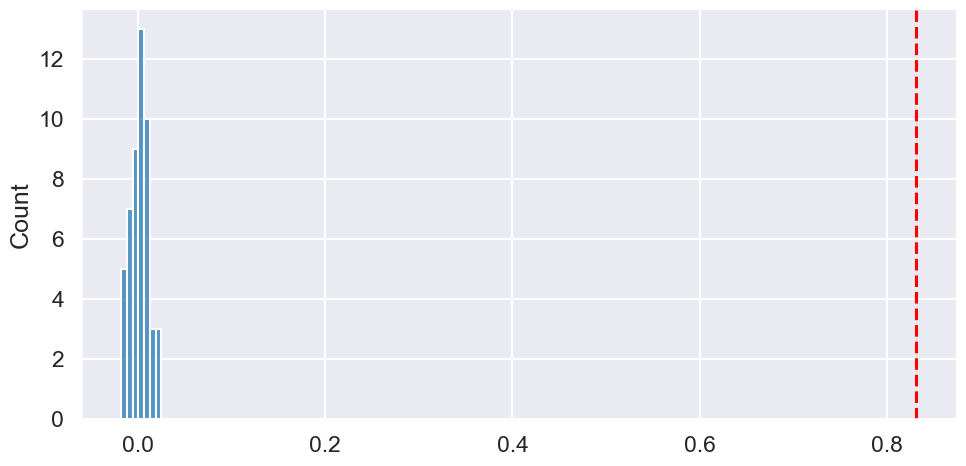

In [494]:
# fig, ax = plt.subplots(figsize=(10,4))
sns.displot(icc_baseline, height=5, aspect=2)
plt.axvline(overall_icc, color='r', linestyle='--')
plt.show()

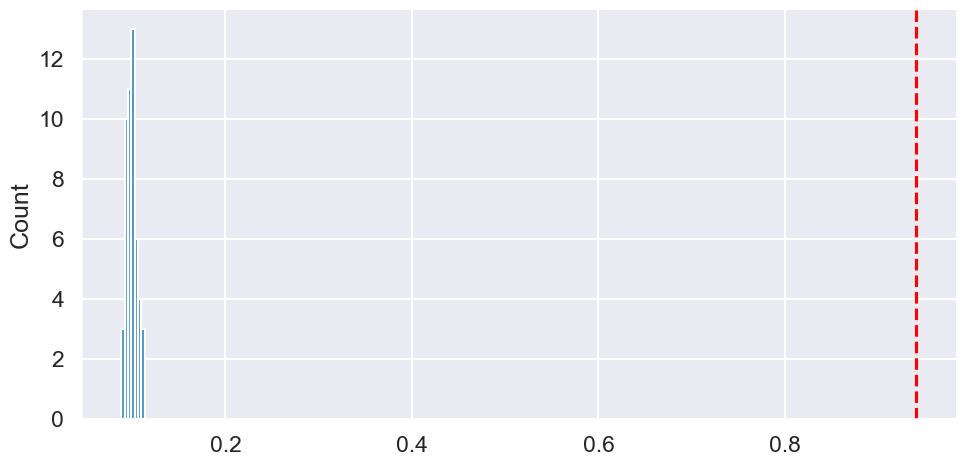

In [495]:
# fig, ax = plt.subplots(figsize=(10,4))
sns.displot(agreement_baseline['block'], height=5, aspect=2)
plt.axvline(prop_all_agree_block, color='r', linestyle='--')
plt.show()

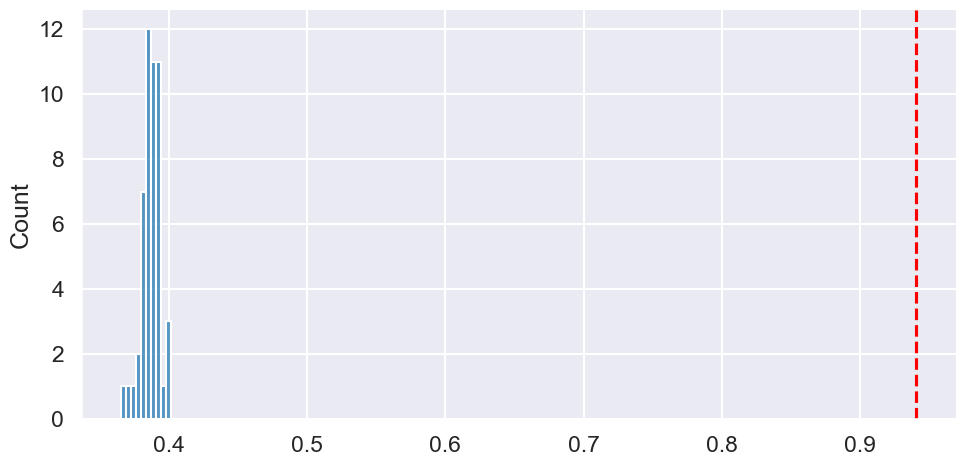

In [496]:
sns.displot(agreement_baseline['tower'], height=5, aspect=2)
plt.axvline(prop_all_agree_tower, color='r', linestyle='--')

# Chi-squared

Compare word frequency distributions using chi-squared test